# Anomaly Detection on Latent Features 

# Isolation Forest

In this notebook, we implement the second stage of the project: **Anomaly Detection (AD)**.
The goal is to detect abnormal machine sounds using the **latent representations** extracted by a previously trained **Convolutional Autoencoder**.

The autoencoder was trained only on *healthy* sounds and acts as a feature extractor.
Here, we use those compressed features as input to an **Isolation Forest**, a classical unsupervised anomaly detection algorithm.

## 1. Imports and Basic Configuration

We start by importing the required Python libraries:
- `os` for interactions with the operating system
- `numpy` for numerical computations,
- `matplotlib` for visualization,
- `scikit-learn` for the Isolation Forest model and evaluation metrics.

These tools are sufficient to train the anomaly detector and evaluate its performance.


In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


## 2. Loading Latent Representations

In this step, we load the **latent features** generated by the encoder part of the autoencoder.

- `latent_normal.npy` contains latent representations of **healthy sounds** used for training.
- `latent_anomaly.npy` contains latent representations of **anomalous sounds** used only for testing.

Each sound is represented as a 3D tensor `(16 × 16 × 128)`, which encodes its most relevant acoustic patterns.


In [23]:
# Paths to the latent feature files generated by the autoencoder encoder
LATENT_NORMAL_PATH  = "../data/latent_normal.npy"
LATENT_ANOMALY_PATH = "../data/latent_anomaly.npy"

# Print current working directory (useful to debug relative paths)
print("Working directory:", os.getcwd())

# Check that the latent feature files exist
print("Exists latent_normal?", os.path.exists(LATENT_NORMAL_PATH), "->", LATENT_NORMAL_PATH)
print("Exists latent_anomaly?", os.path.exists(LATENT_ANOMALY_PATH), "->", LATENT_ANOMALY_PATH)

# Load latent representations from disk
latent_normal  = np.load(LATENT_NORMAL_PATH)
latent_anomaly = np.load(LATENT_ANOMALY_PATH)

# Print basic information about the loaded arrays
print("\nLoaded arrays:")
print("latent_normal.shape :", latent_normal.shape, "dtype:", latent_normal.dtype)
print("latent_anomaly.shape:", latent_anomaly.shape, "dtype:", latent_anomaly.dtype)



Working directory: /app/src
Exists latent_normal? True -> ../data/latent_normal.npy
Exists latent_anomaly? True -> ../data/latent_anomaly.npy

Loaded arrays:
latent_normal.shape : (3009, 16, 16, 128) dtype: float32
latent_anomaly.shape: (300, 16, 16, 128) dtype: float32


## 3. Sanity Checks on the Data

Before training any model, we perform basic sanity checks:
- Verify the shapes of the arrays,
- Check for invalid values such as NaNs or infinities,
- Inspect basic statistics (min, max, mean, standard deviation).

This step ensures that the data is numerically stable and suitable for machine learning.


In [24]:
# Helper function to inspect numerical properties of an array
def describe_array(name, arr):
    print(f"\n--- {name} ---")
    print("shape:", arr.shape, "| dtype:", arr.dtype)
    print("nan count:", np.isnan(arr).sum())
    print("inf count:", np.isinf(arr).sum())
    print("min:", np.min(arr), 
          "max:", np.max(arr), 
          "mean:", np.mean(arr), 
          "std:", np.std(arr))

# Perform sanity checks on both normal and anomalous latent features
describe_array("latent_normal", latent_normal)
describe_array("latent_anomaly", latent_anomaly)




--- latent_normal ---
shape: (3009, 16, 16, 128) | dtype: float32
nan count: 0
inf count: 0
min: 0.0 max: 1.3195143 mean: 0.119419895 std: 0.16899334

--- latent_anomaly ---
shape: (300, 16, 16, 128) | dtype: float32
nan count: 0
inf count: 0
min: 0.0 max: 1.4988554 mean: 0.10992279 std: 0.1735865


## 4. Flattening the Latent Representations

Isolation Forest expects input data in the form `(n_samples, n_features)`.

Therefore, we flatten each latent tensor `(16 × 16 × 128)` into a one-dimensional feature vector.
This transformation does not change the information content, but adapts the data format to the requirements of classical ML algorithms.


In [25]:
# Classical ML models expect 2D input: (n_samples, n_features)
# We flatten each 3D latent tensor (16 x 16 x 128) into a 1D vector

X_normal_flat  = latent_normal.reshape(latent_normal.shape[0], -1)
X_anomaly_flat = latent_anomaly.reshape(latent_anomaly.shape[0], -1)

# Check resulting shapes
print("After flatten:")
print("X_normal_flat.shape :", X_normal_flat.shape)
print("X_anomaly_flat.shape:", X_anomaly_flat.shape)

# Ensure feature dimensions match
assert X_normal_flat.shape[1] == X_anomaly_flat.shape[1]
print("OK: feature dimension =", X_normal_flat.shape[1])


After flatten:
X_normal_flat.shape : (3009, 32768)
X_anomaly_flat.shape: (300, 32768)
OK: feature dimension = 32768


## 5. Train/Test Split on Healthy Data

Following the anomaly detection paradigm:
- We train the model **only on healthy data**.
- We reserve a subset of healthy samples for testing.

We split the healthy latent features into:
- 80% for training the Isolation Forest,
- 20% for testing normal behavior.


In [26]:
# Split healthy data into training and testing subsets
X_train, X_test_healthy = train_test_split(
    X_normal_flat,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Print split sizes
print("Train normals :", X_train.shape)
print("Test healthy  :", X_test_healthy.shape)

# All anomalous samples are used only for testing
X_test_anomaly = X_anomaly_flat
print("Test anomaly  :", X_test_anomaly.shape)



Train normals : (2407, 32768)
Test healthy  : (602, 32768)
Test anomaly  : (300, 32768)


## 6. Building the Final Test Set

The final test set is composed of:
- Healthy samples from the test split,
- All available anomalous samples.

This allows us to evaluate:
- Whether healthy sounds are correctly recognized as normal,
- Whether anomalous sounds are correctly detected as anomalies.


In [27]:
X_test_final = np.concatenate([X_test_healthy, X_test_anomaly], axis=0)

# Create ground-truth labels:
#  1  -> normal
# -1  -> anomaly
y_true_healthy = np.ones(len(X_test_healthy), dtype=int)
y_true_anomaly = -np.ones(len(X_test_anomaly), dtype=int)

y_test_final = np.concatenate([y_true_healthy, y_true_anomaly], axis=0)

# Print final dataset information
print("X_test_final:", X_test_final.shape)
print("y_test_final:", y_test_final.shape)

# Show class distribution
unique, counts = np.unique(y_test_final, return_counts=True)
print("Test label distribution:", dict(zip(unique, counts)))



X_test_final: (902, 32768)
y_test_final: (902,)
Test label distribution: {np.int64(-1): np.int64(300), np.int64(1): np.int64(602)}


## 7. Training the Isolation Forest

We train an Isolation Forest using only healthy samples.

The `contamination` parameter represents the expected fraction of anomalies in the data.
Since we train exclusively on healthy sounds, this value is set to a very small number.

After training, the model is ready to classify unseen samples as normal or anomalous.



In [28]:
# Train Isolation Forest using only healthy samples
# contamination is set low because training data contains no anomalies

print("Training Isolation Forest...")

clf = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train)

print("Model trained.")
print("IF params:", clf.get_params())



Training Isolation Forest...
Model trained.
IF params: {'bootstrap': False, 'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## 8. Predictions and Anomaly Scores

The trained model predicts each test sample as:
- Normal (`1`)
- Anomalous (`-1`)

In addition, we compute anomaly scores using the model’s decision function.
Higher anomaly scores indicate samples that deviate more strongly from normal behavior.

We visualize the score distributions to better understand the separation between normal and anomalous data.


Predicting...
Predictions done.
Pred distribution: {np.int64(-1): np.int64(305), np.int64(1): np.int64(597)}

Score sanity:
decision_function: min -0.09676330048185566 max 0.27940122220244895
anomaly_scores   : min -0.27940122220244895 max 0.09676330048185566


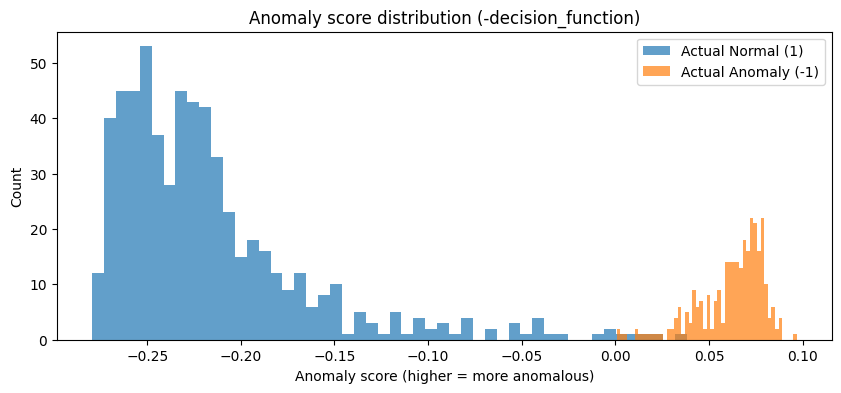

In [29]:
# Predict labels for the final test set
# Output:  1 = normal, -1 = anomaly

print("Predicting...")
y_pred = clf.predict(X_test_final)

print("Predictions done.")
unique, counts = np.unique(y_pred, return_counts=True)
print("Pred distribution:", dict(zip(unique, counts)))

# Compute anomaly scores
# decision_function: higher = more normal
# anomaly score = negative decision function

decision_scores = clf.decision_function(X_test_final)
anomaly_scores  = -decision_scores

print("\nScore sanity:")
print("decision_function: min", decision_scores.min(), "max", decision_scores.max())
print("anomaly_scores   : min", anomaly_scores.min(), "max", anomaly_scores.max())

# Plot anomaly score distributions
plt.figure(figsize=(10, 4))
plt.hist(anomaly_scores[y_test_final == 1], bins=50, alpha=0.7, label="Actual Normal (1)")
plt.hist(anomaly_scores[y_test_final == -1], bins=50, alpha=0.7, label="Actual Anomaly (-1)")
plt.title("Anomaly score distribution (-decision_function)")
plt.xlabel("Anomaly score (higher = more anomalous)")
plt.ylabel("Count")
plt.legend()
plt.show()



## 9. Confusion Matrix

The confusion matrix provides a clear summary of the model’s performance:
- True Positives (correct anomaly detection),
- True Negatives (correct normal detection),
- False Positives (false alarms),
- False Negatives (missed anomalies).

This visualization allows us to quickly assess the strengths and weaknesses of the detector.


<Figure size 600x600 with 0 Axes>

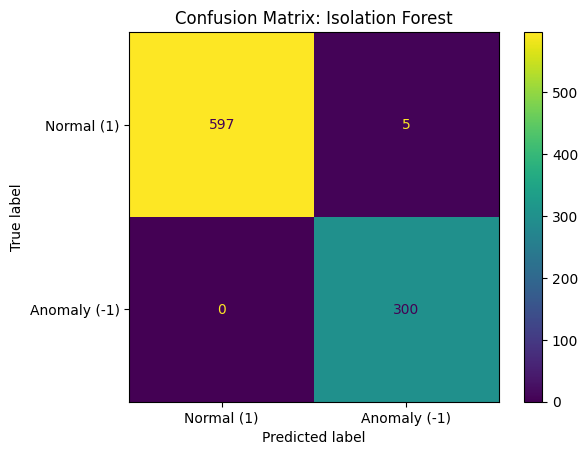

In [30]:
# Compute confusion matrix
# Rows: true labels, Columns: predicted labels

labels = [1, -1]  # order: Normal, Anomaly
cm = confusion_matrix(y_test_final, y_pred, labels=labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Normal (1)", "Anomaly (-1)"]
)

plt.figure(figsize=(6, 6))
disp.plot(values_format="d", cmap=None)
plt.title("Confusion Matrix: Isolation Forest")
plt.show()



## 10. Classification Report

Finally, we compute a classification report including:
- Precision,
- Recall,
- F1-score.

These metrics quantify how well the Isolation Forest distinguishes between normal and anomalous sounds.


In [31]:
# Print precision, recall and F1-score for each class
# This allows a quantitative evaluation of the model performance

from sklearn.metrics import classification_report

print(classification_report(
    y_test_final,
    y_pred,
    labels=[-1, 1],
    target_names=["Anomaly (-1)", "Normal (1)"]
))



              precision    recall  f1-score   support

Anomaly (-1)       0.98      1.00      0.99       300
  Normal (1)       1.00      0.99      1.00       602

    accuracy                           0.99       902
   macro avg       0.99      1.00      0.99       902
weighted avg       0.99      0.99      0.99       902



## 11. Error Analysis: False Positives and False Negatives

To better understand the model behavior, we analyze:
- False Positives: normal sounds incorrectly flagged as anomalies,
- False Negatives: anomalous sounds incorrectly classified as normal.

This analysis is important in predictive maintenance scenarios, where false alarms and missed failures have different practical costs.


In [32]:
import numpy as np

# Identify indices of different prediction outcomes
fp_idx = np.where((y_test_final == 1) & (y_pred == -1))[0]   # normal → anomaly
fn_idx = np.where((y_test_final == -1) & (y_pred == 1))[0]   # anomaly → normal
tp_idx = np.where((y_test_final == -1) & (y_pred == -1))[0]  # anomaly → anomaly
tn_idx = np.where((y_test_final == 1) & (y_pred == 1))[0]    # normal → normal

# Count true samples per class
n_normals = int(np.sum(y_test_final == 1))
n_anoms   = int(np.sum(y_test_final == -1))

# Print basic error statistics
print("=== Error analysis ===")
print(f"Total test samples: {len(y_test_final)}")
print(f"Normals (true=1): {n_normals}")
print(f"Anoms   (true=-1): {n_anoms}\n")

print(f"TN (normal→normal): {len(tn_idx)}")
print(f"FP (normal→anomaly): {len(fp_idx)}")
print(f"FN (anomaly→normal): {len(fn_idx)}")
print(f"TP (anomaly→anomaly): {len(tp_idx)}\n")

# Compute error rates
fpr = len(fp_idx) / n_normals if n_normals else float("nan")
fnr = len(fn_idx) / n_anoms if n_anoms else float("nan")

print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

# Show first error indices
print("\nFirst 10 FP indexes:", fp_idx[:10])
print("First 10 FN indexes:", fn_idx[:10])


=== Error analysis ===
Total test samples: 902
Normals (true=1): 602
Anoms   (true=-1): 300

TN (normal→normal): 597
FP (normal→anomaly): 5
FN (anomaly→normal): 0
TP (anomaly→anomaly): 300

False Positive Rate (FPR): 0.0083
False Negative Rate (FNR): 0.0000

First 10 FP indexes: [ 17 115 144 218 488]
First 10 FN indexes: []



--- False Positives (normal predicted as anomaly) (showing up to 10) ---
idx=144 | anomaly_score=0.038193
idx=218 | anomaly_score=0.021225
idx=115 | anomaly_score=0.016738
idx=17 | anomaly_score=0.009194
idx=488 | anomaly_score=0.005715

--- False Negatives (anomaly predicted as normal) (showing up to 10) ---


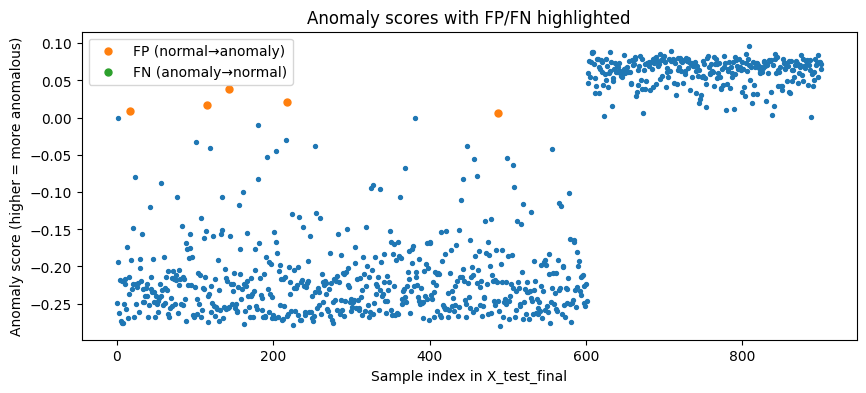

In [33]:
import matplotlib.pyplot as plt

# Helper function to print example indices and scores
def show_examples(indices, title, max_show=10):
    print(f"\n--- {title} (showing up to {max_show}) ---")
    for i in indices[:max_show]:
        msg = f"idx={i}"
        if "anomaly_scores" in globals():
            msg += f" | anomaly_score={anomaly_scores[i]:.6f}"
        print(msg)

# Sort errors by anomaly score (if available)
if "anomaly_scores" in globals():
    fp_sorted = fp_idx[np.argsort(anomaly_scores[fp_idx])[::-1]]
    fn_sorted = fn_idx[np.argsort(anomaly_scores[fn_idx])[::-1]]
else:
    fp_sorted = fp_idx
    fn_sorted = fn_idx

show_examples(fp_sorted, "False Positives (normal predicted as anomaly)")
show_examples(fn_sorted, "False Negatives (anomaly predicted as normal)")

# Plot anomaly scores and highlight FP and FN samples
if "anomaly_scores" in globals():
    plt.figure(figsize=(10, 4))
    plt.scatter(np.arange(len(anomaly_scores)), anomaly_scores, s=8)
    plt.scatter(fp_idx, anomaly_scores[fp_idx], s=25, label="FP (normal→anomaly)")
    plt.scatter(fn_idx, anomaly_scores[fn_idx], s=25, label="FN (anomaly→normal)")
    plt.title("Anomaly scores with FP/FN highlighted")
    plt.xlabel("Sample index in X_test_final")
    plt.ylabel("Anomaly score (higher = more anomalous)")
    plt.legend()
    plt.show()
else:
    print("\nNo anomaly_scores found in globals().")
    print("Compute them using:")
    print("anomaly_scores = -clf.decision_function(X_test_final)")

# One-Class SVM Baseline



In this section we implement **One-Class SVM (OCSVM)** as an additional anomaly detection model.
OCSVM learns a boundary around the **healthy training samples** and flags samples outside that boundary as anomalies.

This block is executed **after** the Isolation Forest section and reuses the same:
- `X_train` (healthy training features only)
- `X_test_final` (healthy + anomalous test features)
- `y_test_final` (ground-truth labels: `1` normal, `-1` anomaly)

We evaluate the model using:
- anomaly score distributions,
- confusion matrix,
- classification report.


## 1) Input Checks

Before training, we verify that the data is in the correct format for SVM:
- 2D arrays `(n_samples, n_features)`
- labels in `{-1, 1}`
- consistent number of samples between `X_test_final` and `y_test_final`


In [34]:
# Basic input validation before training the One-Class SVM

import numpy as np

print("X_train shape      :", X_train.shape)
print("X_test_final shape :", X_test_final.shape)
print("y_test_final shape :", y_test_final.shape)

# Ensure correct dimensionality and label format
assert X_train.ndim == 2 and X_test_final.ndim == 2, \
    "OCSVM expects 2D arrays (n_samples, n_features)"
assert len(X_test_final) == len(y_test_final), \
    "X_test_final and y_test_final must have the same length"
assert set(np.unique(y_test_final)).issubset({-1, 1}), \
    "Expected labels in {-1, 1}"

unique, counts = np.unique(y_test_final, return_counts=True)
print("Test label distribution:", dict(zip(unique, counts)))



X_train shape      : (2407, 32768)
X_test_final shape : (902, 32768)
y_test_final shape : (902,)
Test label distribution: {np.int64(-1): np.int64(300), np.int64(1): np.int64(602)}


## 2) Model Definition (Scaling + One-Class SVM)

SVM-based methods are highly sensitive to feature scaling.
For this reason, we apply a `StandardScaler` before the One-Class SVM.

Key parameters:
- `nu`: expected fraction of outliers (higher values → more samples flagged as anomalies)
- `gamma`: controls the boundary complexity for the RBF kernel (`"scale"` is a safe default)


In [35]:
# Define a pipeline with feature scaling followed by One-Class SVM

from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

NU = 0.001
GAMMA = "scale"

ocsvm = Pipeline([
    ("scaler", StandardScaler()),
    ("model", OneClassSVM(kernel="rbf", nu=NU, gamma=GAMMA))
])

print("Training One-Class SVM...")
ocsvm.fit(X_train)
print("Done.")
print("OCSVM params:", ocsvm.named_steps["model"].get_params())



Training One-Class SVM...
Done.
OCSVM params: {'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'nu': 0.001, 'shrinking': True, 'tol': 0.001, 'verbose': False}


## 3) Predictions and Anomaly Scores

The model outputs:
- `1` for normal samples (inliers)
- `-1` for anomalous samples (outliers)

We also compute scores for interpretability:
- `decision_function(X)` is typically higher for normal samples
- we define an anomaly score as `-decision_function(X)` so that higher values indicate more anomalous behavior


Prediction distribution (1=normal, -1=anomaly): {np.int64(-1): np.int64(333), np.int64(1): np.int64(569)}
Score sanity:
decision_function: min -0.06982877428002043 max 0.05513027142803735
anomaly_scores   : min -0.05513027142803735 max 0.06982877428002043


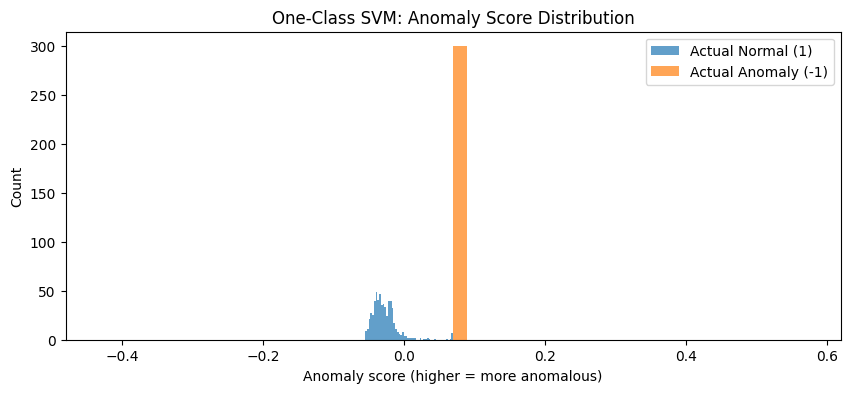

In [36]:
# Predict labels using the One-Class SVM
# Output:  1 = normal, -1 = anomaly

import matplotlib.pyplot as plt

y_pred_ocsvm = ocsvm.predict(X_test_final)

# Compute decision function and anomaly scores
decision_scores = ocsvm.decision_function(X_test_final)  # higher = more normal
anomaly_scores_ocsvm = -decision_scores                  # higher = more anomalous

print("Prediction distribution (1=normal, -1=anomaly):",
      dict(zip(*np.unique(y_pred_ocsvm, return_counts=True))))

print("Score sanity:")
print("decision_function: min", decision_scores.min(), "max", decision_scores.max())
print("anomaly_scores   : min", anomaly_scores_ocsvm.min(), "max", anomaly_scores_ocsvm.max())

# Plot score distributions
plt.figure(figsize=(10, 4))
plt.hist(anomaly_scores_ocsvm[y_test_final == 1], bins=50, alpha=0.7, label="Actual Normal (1)")
plt.hist(anomaly_scores_ocsvm[y_test_final == -1], bins=50, alpha=0.7, label="Actual Anomaly (-1)")
plt.title("One-Class SVM: Anomaly Score Distribution")
plt.xlabel("Anomaly score (higher = more anomalous)")
plt.ylabel("Count")
plt.legend()
plt.show()



## 4) Confusion Matrix

The confusion matrix summarizes:
- True Negatives (normal correctly classified),
- False Positives (false alarms),
- False Negatives (missed anomalies),
- True Positives (anomalies correctly detected).


<Figure size 600x600 with 0 Axes>

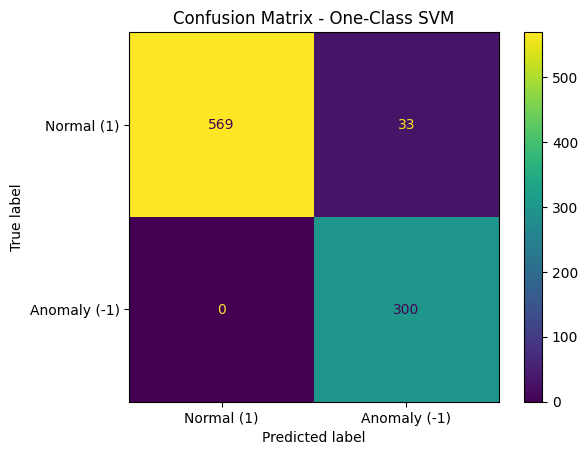

In [37]:
# Confusion matrix: compares ground truth vs predicted labels

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = [1, -1]  # order: Normal, Anomaly

cm_ocsvm = confusion_matrix(y_test_final, y_pred_ocsvm, labels=labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_ocsvm,
    display_labels=["Normal (1)", "Anomaly (-1)"]
)

plt.figure(figsize=(6, 6))
disp.plot(values_format="d", cmap=None)
plt.title("Confusion Matrix - One-Class SVM")
plt.show()



## 5) Classification Report

We report precision, recall and F1-score for both classes to quantify performance.
This output can be compared directly with the Isolation Forest report since both use the same test set and label convention.


In [38]:
# Print precision, recall and F1-score for OCSVM
# This can be compared directly to Isolation Forest results

from sklearn.metrics import classification_report

print(classification_report(
    y_test_final,
    y_pred_ocsvm,
    labels=[-1, 1],
    target_names=["Anomaly (-1)", "Normal (1)"]
))


              precision    recall  f1-score   support

Anomaly (-1)       0.90      1.00      0.95       300
  Normal (1)       1.00      0.95      0.97       602

    accuracy                           0.96       902
   macro avg       0.95      0.97      0.96       902
weighted avg       0.97      0.96      0.96       902



## 6) Quick Comparison vs Isolation Forest

To compare models under the same conditions, we compute:
- False Positive Rate (FPR): fraction of normal samples incorrectly flagged as anomalies
- False Negative Rate (FNR): fraction of anomalies incorrectly classified as normal

Lower values are better for both metrics.


In [39]:
# Compute FPR and FNR for a fair comparison between models
# Lower values are better for both metrics

import numpy as np

def fpr_fnr(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    n_norm = np.sum(y_true == 1)
    n_anom = np.sum(y_true == -1)

    fp = np.sum((y_true == 1) & (y_pred == -1))
    fn = np.sum((y_true == -1) & (y_pred == 1))

    fpr = fp / n_norm if n_norm else float("nan")
    fnr = fn / n_anom if n_anom else float("nan")
    return fpr, fnr, int(fp), int(fn), int(n_norm), int(n_anom)

print("OCSVM:")
fpr, fnr, fp, fn, n_norm, n_anom = fpr_fnr(y_test_final, y_pred_ocsvm)
print(f"  FPR={fpr:.4f} ({fp}/{n_norm}) | FNR={fnr:.4f} ({fn}/{n_anom})")

# If Isolation Forest predictions exist, print them as well
if "y_pred" in globals():
    print("\nIsolation Forest:")
    fpr, fnr, fp, fn, n_norm, n_anom = fpr_fnr(y_test_final, y_pred)
    print(f"  FPR={fpr:.4f} ({fp}/{n_norm}) | FNR={fnr:.4f} ({fn}/{n_anom})")
else:
    print("\nIsolation Forest predictions not found (variable `y_pred`).")



OCSVM:
  FPR=0.0548 (33/602) | FNR=0.0000 (0/300)

Isolation Forest:
  FPR=0.0083 (5/602) | FNR=0.0000 (0/300)


## 7) Decision Boundary Visualization (2D Projection)

The One-Class SVM is trained in a **high-dimensional feature space**, so we cannot directly visualize its boundary.
To provide an intuitive interpretation, we project the latent vectors to **2D using PCA** and train an additional
One-Class SVM in this 2D space **only for visualization**.

Important note:
- The evaluation metrics above are computed using the original high-dimensional features.
- The 2D boundary shown here is an explanatory visualization, not the exact decision surface in the original space.


In [40]:
# IMPORTANT:
# The OCSVM is trained on high-dimensional features (e.g., 32768D),
# so we cannot directly plot its true decision boundary.
# Here we project features to 2D with PCA only for visualization.

from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)

# Fit PCA on training data and transform both train and test
X_train_2d = pca.fit_transform(X_train)
X_test_2d  = pca.transform(X_test_final)

# Print how much variance each component explains
print("PCA explained variance ratio:", pca.explained_variance_ratio_)
print("Train 2D shape:", X_train_2d.shape)
print("Test 2D shape :", X_test_2d.shape)



PCA explained variance ratio: [0.49556407 0.12334854]
Train 2D shape: (2407, 2)
Test 2D shape : (902, 2)


PCA explained variance ratio: [0.43685704 0.11741304]
Train 2D shape: (2407, 2) | Test 2D shape: (902, 2)


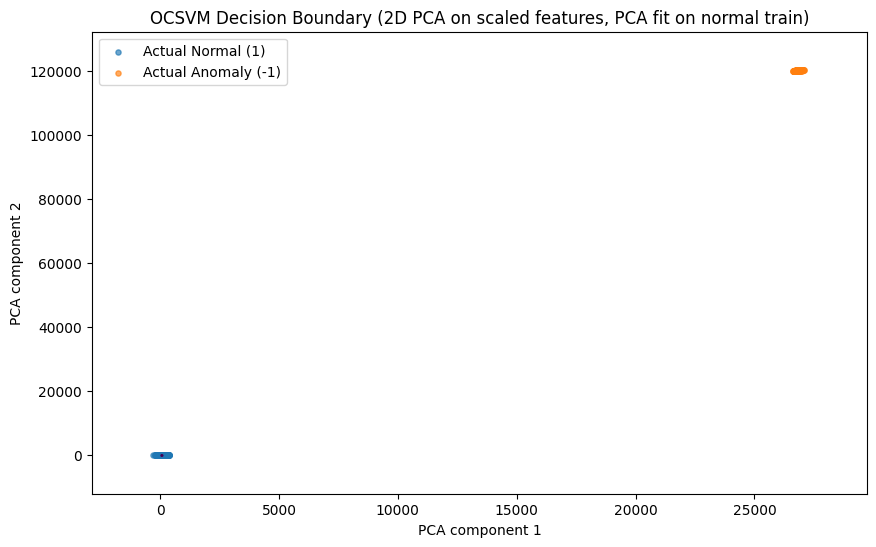

Points shown in view: 902/902 (clipped 0)


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

# -----------------------------
# Goal:
# Produce a cleaner 2D visualization by:
# 1) scaling features,
# 2) fitting PCA only on NORMAL training data,
# 3) using robust plot limits (percentiles) to avoid extreme outliers stretching the axes,
# 4) plotting an OCSVM boundary trained in 2D ONLY for visualization.
# -----------------------------

# 0) Basic masks (used for plotting)
mask_normal = (y_test_final == 1)
mask_anom   = (y_test_final == -1)

# 1) Scale features (same spirit as OCSVM pipeline)
scaler_vis = StandardScaler()
X_train_scaled = scaler_vis.fit_transform(X_train)        # normal-only training set
X_test_scaled  = scaler_vis.transform(X_test_final)       # mixed test set

# 2) PCA fitted on NORMAL training data only (more coherent for one-class setting)
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train_scaled)
X_test_2d  = pca.transform(X_test_scaled)

print("PCA explained variance ratio:", pca.explained_variance_ratio_)
print("Train 2D shape:", X_train_2d.shape, "| Test 2D shape:", X_test_2d.shape)

# 3) Fit a 2D OCSVM ONLY for visualization (proxy boundary in the projected space)
NU = ocsvm.named_steps["model"].nu
GAMMA = ocsvm.named_steps["model"].gamma

ocsvm_2d = OneClassSVM(kernel="rbf", nu=NU, gamma=GAMMA)
ocsvm_2d.fit(X_train_2d)

# 4) Robust axis limits to prevent a few extreme points from destroying visibility
#    (adjust percentiles if needed: e.g. 0.5/99.5)
x_lo, x_hi = np.percentile(X_test_2d[:, 0], [1, 99])
y_lo, y_hi = np.percentile(X_test_2d[:, 1], [1, 99])

# Add a small margin so the boundary is not clipped
x_pad = 0.10 * (x_hi - x_lo + 1e-9)
y_pad = 0.10 * (y_hi - y_lo + 1e-9)

x_min, x_max = x_lo - x_pad, x_hi + x_pad
y_min, y_max = y_lo - y_pad, y_hi + y_pad

# 5) Create grid and evaluate the 2D OCSVM decision function
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = ocsvm_2d.decision_function(grid).reshape(xx.shape)  # boundary at 0

# 6) Plot
plt.figure(figsize=(10, 6))

# Optional: plot only points inside the visible range for clarity
in_view = (
    (X_test_2d[:, 0] >= x_min) & (X_test_2d[:, 0] <= x_max) &
    (X_test_2d[:, 1] >= y_min) & (X_test_2d[:, 1] <= y_max)
)

plt.scatter(X_test_2d[in_view & mask_normal, 0], X_test_2d[in_view & mask_normal, 1],
            s=14, alpha=0.65, label="Actual Normal (1)")
plt.scatter(X_test_2d[in_view & mask_anom, 0], X_test_2d[in_view & mask_anom, 1],
            s=14, alpha=0.65, label="Actual Anomaly (-1)")

# Decision boundary (level=0)
plt.contour(xx, yy, Z, levels=[0], linewidths=2)

plt.title("OCSVM Decision Boundary (2D PCA on scaled features, PCA fit on normal train)")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.show()

# 7) Quick sanity print: how many points were clipped by percentile view?
n_total = len(X_test_2d)
n_in_view = int(np.sum(in_view))
print(f"Points shown in view: {n_in_view}/{n_total} (clipped {n_total - n_in_view})")

